In [10]:
import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import json

# Load Data Pada CSV dan Proses menjadi Data Time Series

In [39]:
#Load data csv dan format data tahun bulan menjadi data frame
df = pd.read_csv('DATASET_PAJAK_HOTEL.csv')
df['tahun'] = pd.to_datetime(df['tahun_bulan'])

In [40]:
#Buat data tiemseries berdasar key value dari data frame
dts = pd.Series(data=df['jml_setor'].values, index=df['tahun'])
dts.info()
json_data = dts.to_json(date_format='iso')
print(json_data)
with open('./datasets/hotel.json', 'w') as f:
    json.dump(json_data, f) 

<class 'pandas.core.series.Series'>
DatetimeIndex: 132 entries, 2012-01-01 to 2022-12-01
Series name: None
Non-Null Count  Dtype
--------------  -----
132 non-null    int64
dtypes: int64(1)
memory usage: 2.1 KB
{"2012-01-01T00:00:00.000":183057000,"2012-02-01T00:00:00.000":227826558,"2012-03-01T00:00:00.000":183871650,"2012-04-01T00:00:00.000":210447250,"2012-05-01T00:00:00.000":133266850,"2012-06-01T00:00:00.000":219206350,"2012-07-01T00:00:00.000":124164400,"2012-08-01T00:00:00.000":134640450,"2012-09-01T00:00:00.000":212564750,"2012-10-01T00:00:00.000":173935750,"2012-11-01T00:00:00.000":416368000,"2012-12-01T00:00:00.000":275352000,"2013-01-01T00:00:00.000":349926250,"2013-02-01T00:00:00.000":206785000,"2013-03-01T00:00:00.000":298419900,"2013-04-01T00:00:00.000":520294250,"2013-05-01T00:00:00.000":401312500,"2013-06-01T00:00:00.000":346875000,"2013-07-01T00:00:00.000":316110000,"2013-08-01T00:00:00.000":209607500,"2013-09-01T00:00:00.000":404187500,"2013-10-01T00:00:00.000":375347

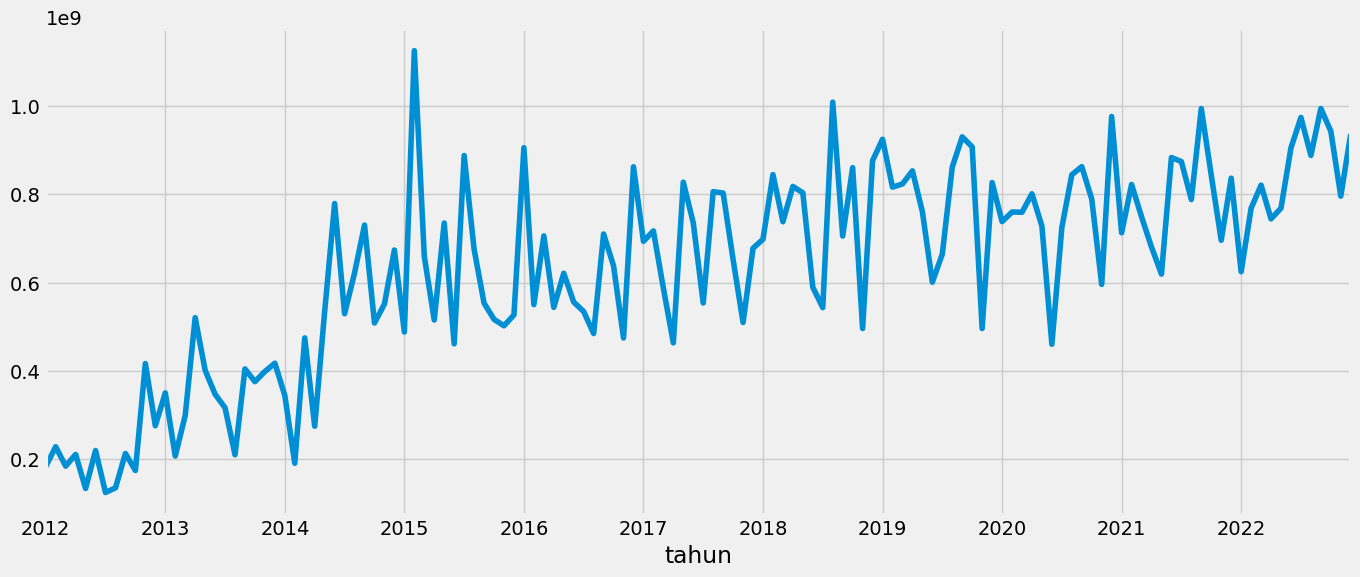

In [41]:
#data deret waktu menjadi chart
dts.plot(figsize=(15, 6))
plt.show()

# Mencari parameter terbaik ARIMA p, d, q

In [5]:
# Tentukan parameter p, d, dan q untuk mengambil nilai antara 0 sampai 2
p = d = q = range(0, 2)
# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))
# Hasilkan semua kombinasi berbeda dari triplet p, q, dan q musiman
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [26]:
warnings.filterwarnings("ignore")  # specify to ignore warning messages
best_result = [0, 0, 10000000]
p_params = [0, 1, 2, 3]
d_params = [0, 1, 2]
q_params = [0, 1, 2, 3]
P_params = [0, 1, 2, 3]
D_params = [0, 1, 2]
Q_params = [0, 1, 2, 3]
for p in p_params:
    for d in d_params:
        for q in q_params:
            for P in P_params:
                for D in D_params:
                    for Q in Q_params:
                        param = [p, d, q]
                        param_seasonal = [P, D, Q, 12]
                        try:
                            mod = sm.tsa.statespace.SARIMAX(dts, order=param, seasonal_order=param_seasonal)
                            results = mod.fit()
                            if results.aic < best_result[2]:
                                if results.aic > 300:
                                    best_result = [param, param_seasonal, results.aic]
                                    print('Best Result:', best_result)
                        except:
                            continue
print('\nBest Result:', best_result)

Best Result: [[0, 0, 0], [0, 0, 1, 12], 5710.737004807459]
Best Result: [[0, 0, 0], [0, 0, 3, 12], 5564.218680112954]
Best Result: [[0, 0, 0], [0, 1, 0, 12], 4932.528740884519]
Best Result: [[0, 0, 0], [0, 2, 1, 12], 4451.929514479323]
Best Result: [[0, 0, 0], [0, 2, 2, 12], 4439.77476185388]
Best Result: [[2, 1, 3], [0, 2, 2, 12], 4437.328618869783]
Best Result: [[2, 2, 2], [0, 2, 2, 12], 4434.302945476595]
Best Result: [[2, 2, 3], [0, 2, 1, 12], 4423.7598373046585]
Best Result: [[2, 2, 3], [0, 2, 2, 12], 4419.828242449854]
Best Result: [[2, 2, 3], [1, 2, 1, 12], 4419.729581454067]
Best Result: [[3, 2, 3], [0, 2, 1, 12], 4416.547515482369]
Best Result: [[3, 2, 3], [0, 2, 2, 12], 4408.560808304359]

Best Result: [[3, 2, 3], [0, 2, 2, 12], 4408.560808304359]


# Plot model diagnostics

In [42]:
# latih model dengan dataset dan parameter optimal
mod = sm.tsa.statespace.SARIMAX(dts, order=(3, 2, 3), seasonal_order=(0, 2, 2, 12),
                                enforce_stationarity=True,enforce_invertibility=True,)
results = mod.fit()
print(results.summary())

                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  132
Model:             SARIMAX(3, 2, 3)x(0, 2, [1, 2], 12)   Log Likelihood               -2188.791
Date:                                 Thu, 30 Mar 2023   AIC                           4395.581
Time:                                         04:30:04   BIC                           4419.552
Sample:                                     01-01-2012   HQIC                          4405.297
                                          - 12-01-2022                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5319      1.675     -0.317      0.751      -3.816       2

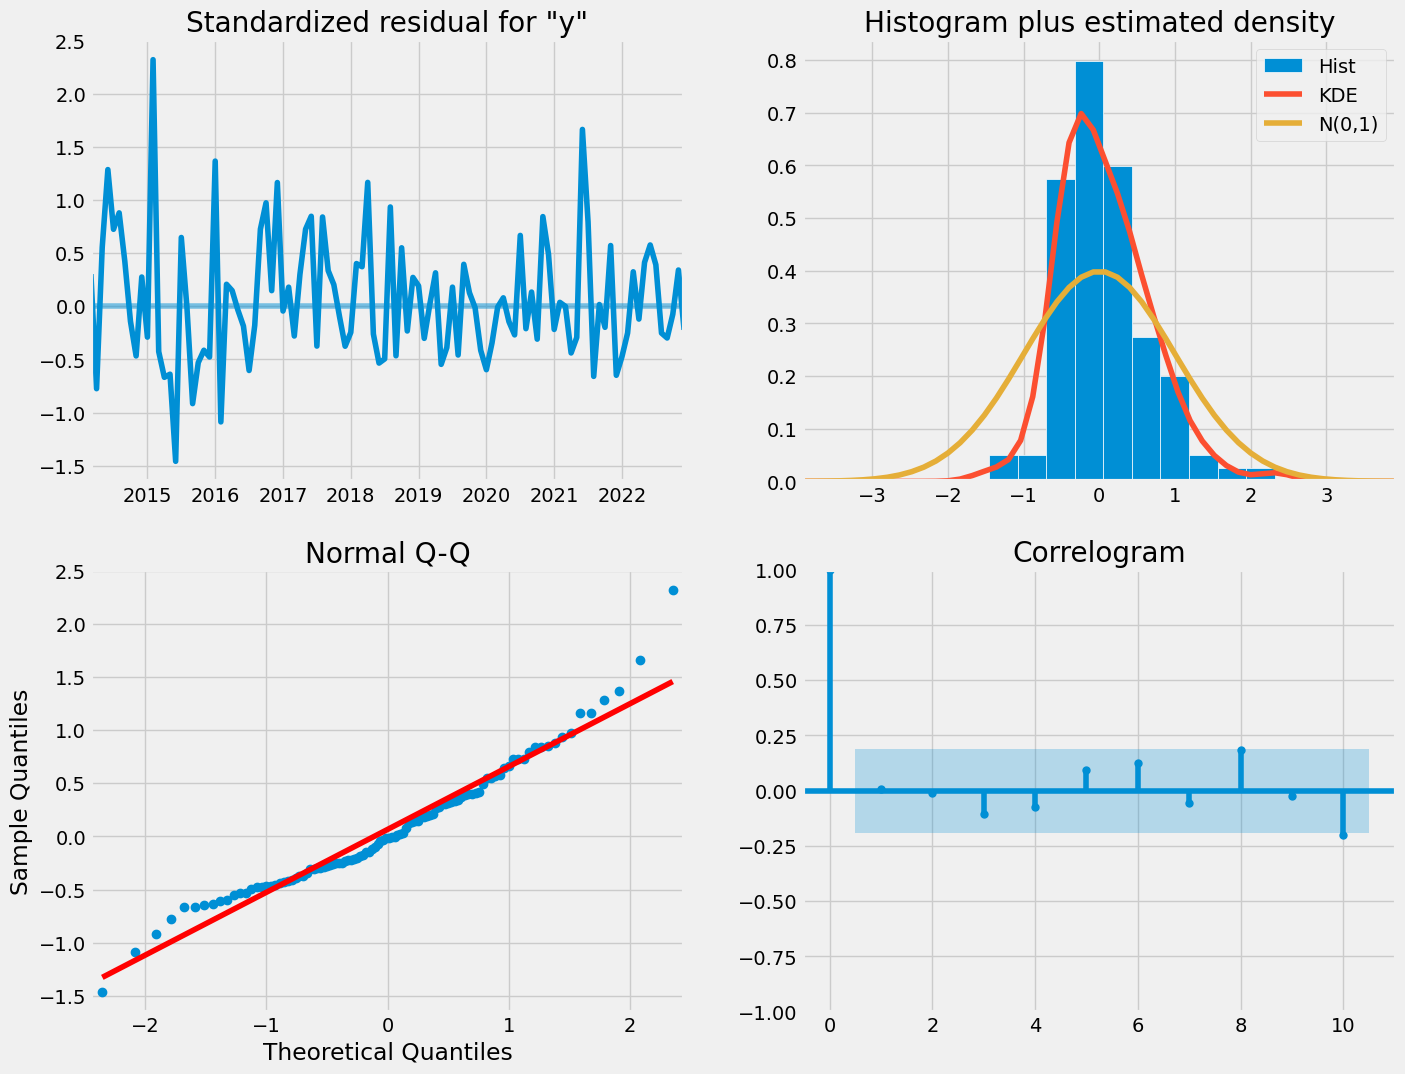

In [43]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

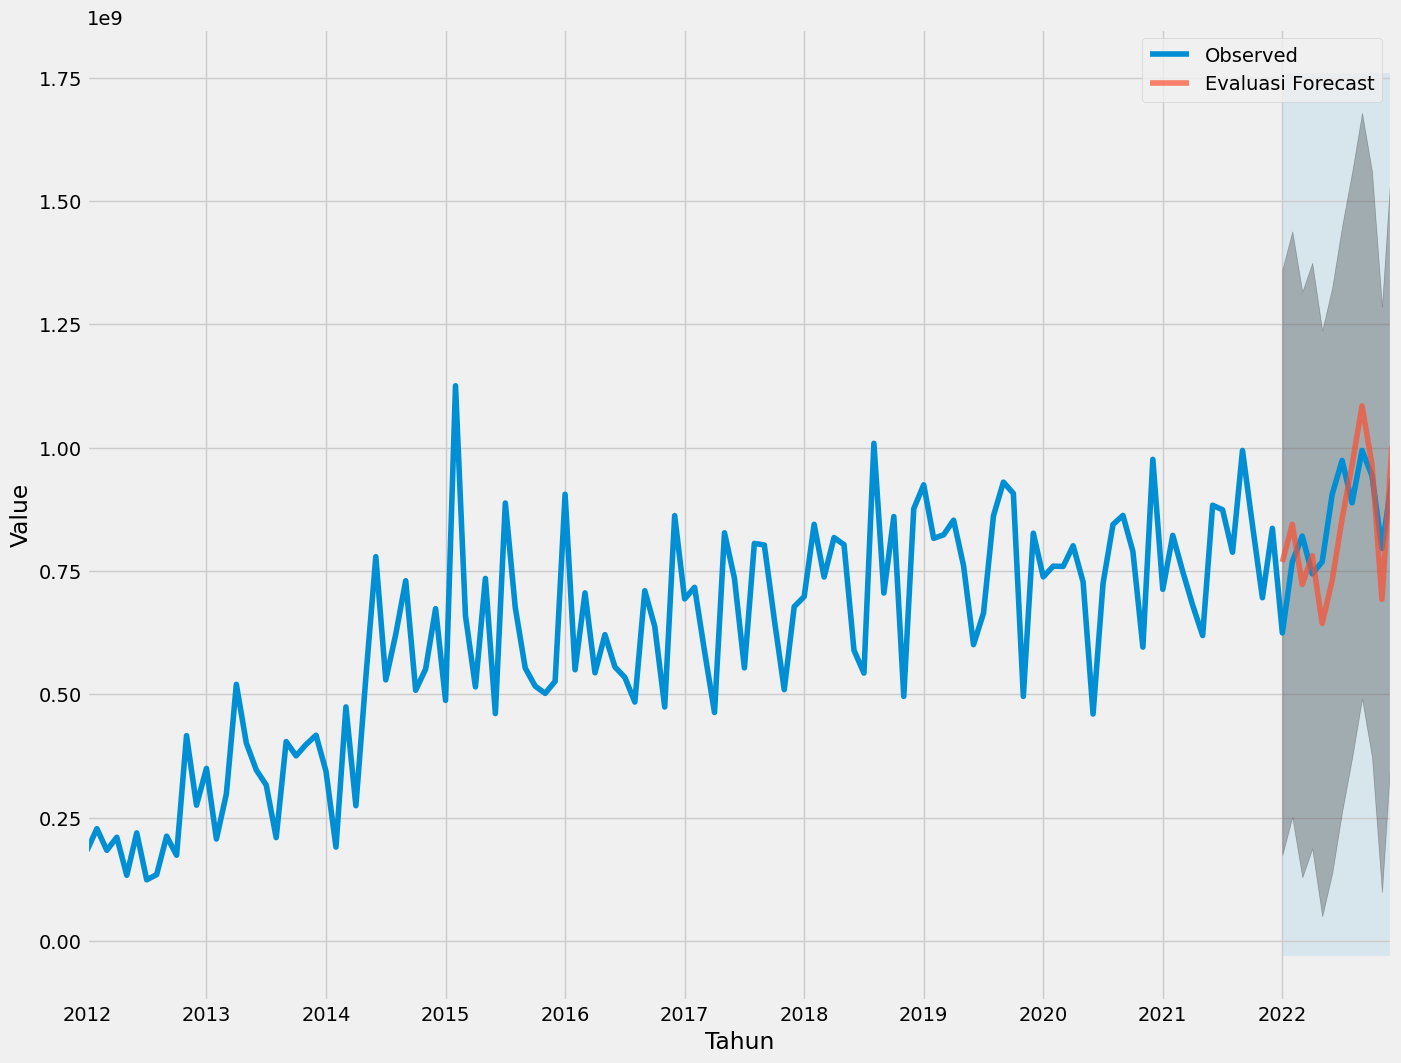

{"2022-01-01T00:00:00.000":768199885.7037291527,"2022-02-01T00:00:00.000":844680413.3231214285,"2022-03-01T00:00:00.000":722567888.7345184088,"2022-04-01T00:00:00.000":780913301.4212510586,"2022-05-01T00:00:00.000":643737546.5225250721,"2022-06-01T00:00:00.000":730593561.2615158558,"2022-07-01T00:00:00.000":855941584.2798966169,"2022-08-01T00:00:00.000":964457095.0293316841,"2022-09-01T00:00:00.000":1084821412.3577780724,"2022-10-01T00:00:00.000":965878689.4651510715,"2022-11-01T00:00:00.000":692561377.4904066324,"2022-12-01T00:00:00.000":1003566141.1866819859}


In [44]:
# prediksi data 2 tahun terbaru dari dataset dan bandingkan
pred = results.get_prediction(start=pd.to_datetime('2022-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = dts['2012':].plot(label='Observed', figsize=(15, 12))
pred.predicted_mean.plot(ax=ax, label='Evaluasi Forecast', alpha=.7)
ax.fill_between(pred_ci.index,pred_ci.iloc[:, 0],pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2022-01-01'), dts.index[-1],alpha=.1, zorder=-1)
ax.set_xlabel('Tahun')
ax.set_ylabel('Value')
plt.legend()
plt.show()

json_data = pred.predicted_mean.to_json(date_format='iso')
print(json_data)
with open('./datasets/hotel_predicted_ahead.json', 'w') as f:
    json.dump(json_data, f)

In [24]:
# Extract the predicted and true values of our time series
y_forecasted = pred.predicted_mean
y_truth = dts['2020-01-01':]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error forecasts adalah {}'.format(round(mse, 2)))

The Mean Squared Error forecasts adalah 4.151912487955633e+16


# Prediksi data selama 2 tahun

In [1]:
# prediksi 24 langkah ke depan di masa mendatang
pred_uc = results.get_forecast(steps=24, dynamic=False)
pred_ci = pred_uc.conf_int()
ax = dts.plot(label='Observed', figsize=(15, 12))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Tahun')
ax.set_ylabel('Jumlah')
plt.legend()
plt.show()


json_data = pred_uc.predicted_mean.to_json(date_format='iso')
print(json_data)
with open('./datasets/hotel_predicted.json', 'w') as f:
    json.dump(json_data, f) 

NameError: name 'results' is not defined